In [1]:
# Plot nice and large
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [10, 6] # Make plots bigger than default

# Import airfoil designer modules
from af_bezier import * 
from af_ui import * 
from af_pac import * 
from af_analysis import * 

In [2]:
# Import some widgets
import ipywidgets as widgets
from ipywidgets import interactive, interact
from ipywidgets import FloatSlider

# Default to read. After running this cell this is loaded.
# Airfoil codes can be found in [1]
kparam = B64read("k1aVYk1WmX7zF8B")

# "global" variables, i.e. those that I want to use from within the widget-functions. Probably not the intended way.
X = []
P = []
SR = []

# I know, very elegant.
# k1 to k15 are the parameters as in [1]
k1=FloatSlider(value = kparam[0], min=0, max=1, step=0.01, continuous_update=False,description="Nose Thck")
k2=FloatSlider(value = kparam[1], min=0, max=1, step=0.01, continuous_update=False,description="Lead Point")
k3=FloatSlider(value = kparam[2], min=0, max=1, step=0.01, continuous_update=False,description="Mid Point")
k4=FloatSlider(value = kparam[3], min=0, max=1, step=0.01, continuous_update=False,description="Trail Point")
k5=FloatSlider(value = kparam[4], min=0, max=1, step=0.01, continuous_update=False,description="Thickness")
k6=FloatSlider(value = kparam[5], min=0, max=1, step=0.01, continuous_update=False,description="Nose Thck")
k7=FloatSlider(value = kparam[6], min=0, max=1, step=0.01, continuous_update=False,description="Lead Point")
k8=FloatSlider(value = kparam[7], min=0, max=1, step=0.01, continuous_update=False,description="Mid Point")
k9=FloatSlider(value = kparam[8], min=0, max=1, step=0.01, continuous_update=False,description="Trail Point")
k10=FloatSlider(value = kparam[9], min=0, max=1, step=0.01, continuous_update=False,description="Thickness")
k11=FloatSlider(value = kparam[10], min=0, max=1, step=0.01, continuous_update=False,description="Top Len")
k12=FloatSlider(value = kparam[11], min=0, max=1, step=0.01, continuous_update=False,description="Bottom Len")
k13=FloatSlider(value = kparam[12], min=0, max=1, step=0.01, continuous_update=False,description="Angle Legs")
k14=FloatSlider(value = kparam[13], min=0, max=1, step=0.01, continuous_update=False,description="Angle TE")
k15=FloatSlider(value = kparam[14], min=0, max=1, step=0.01, continuous_update=False,description="Gap")


# Widget function
def manipulateAirfoil(k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,N,LEFAC,TEFAC,KAPFAC):
    
    # Airfoil Coordinates
    global P # Set of Bezier Points
    global kparam # k1 to k15
    ax=[]
    for kp in range(15):
        kparam[kp] = eval("k%u"%(kp+1))
    P = foilPoints(kparam)
    ds = 0.002
    (T,ArcPoints,Curvature) = pointsByArcLength(P,np.arange(0,1+ds,ds))
    (S,_,_) = getLength(P)
    
    # Airfoil Discretization
    global X # Airfoil coordinates
    global SR # Arclength discretization
    Curvature = discreteCurvature(ArcPoints)
    SR = repanelArclength(np.arange(0,1+ds,ds)*S,Curvature,ArcPoints[0,:],int(N),LEFAC,TEFAC,KAPFAC)
    (_,X,_) = pointsByArcLength(P,SR/max(SR))
    bezierPlot(ax,P);
    plt.plot(X[0,:],X[1,:],"+",color="#AAAAAA")
    plt.plot(X[0,:],X[1,:],"-k")
    plt.axis('equal')
    print("Airfoil Code:" + B64write(kparam))
    
# Set up the sliders
paramtop = widgets.VBox([widgets.HTML(
    value="Top Side Parameter"
),k1,k2,k3,k4,k5])
parambottom = widgets.VBox([widgets.HTML(
    value="Bottom Side Parameter"
),k6,k7,k8,k9,k10])
paramte = widgets.VBox([widgets.HTML(
    value="Trailing Edge Parameter"
),k11,k12,k13,k14,k15])
paramdisc = widgets.VBox([widgets.HBox([N,KAPFAC]),widgets.HBox([LEFAC,TEFAC])])
paramfoil = widgets.HBox([paramtop, parambottom,paramte])
ui = widgets.VBox([paramfoil,widgets.HTML(
    value="Discretization Parameter"
),paramdisc])

# Again, very elegant.
out=widgets.interactive_output(manipulateAirfoil, {'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,
                                                'k6':k6,'k7':k7,'k8':k8,'k9':k9,'k10':k10,
                                                'k11':k11,'k12':k12,'k13':k13,'k14':k14,'k15':k15,
                                                'N':N,'LEFAC':LEFAC,'TEFAC':TEFAC,'KAPFAC':KAPFAC})
display(ui, out)

Output()

In [4]:
# Save discretized airfoil points, if you want
save_points('Airfoil.dat',X,'Airfoil')

In [3]:
# Calculate a polar, here with viiflow
(alv,clv,cdv,cmv,bl,p) = viiflowPolar(X,np.arange(-10,20,.5),1e6,9,0)

AL: 5.000000 CL: 0.995697 CD: 0.013814
AL: 5.500000 CL: 1.049463 CD: 0.014397
AL: 6.000000 CL: 1.101511 CD: 0.015035
AL: 6.500000 CL: 1.154122 CD: 0.015634
AL: 7.000000 CL: 1.204494 CD: 0.016379
AL: 7.500000 CL: 1.255495 CD: 0.016960
AL: 8.000000 CL: 1.304172 CD: 0.017823
AL: 8.500000 CL: 1.353082 CD: 0.018517
AL: 9.000000 CL: 1.398283 CD: 0.019529
AL: 9.500000 CL: 1.443317 CD: 0.020388
AL: 10.000000 CL: 1.483369 CD: 0.021649
AL: 10.500000 CL: 1.523814 CD: 0.022662
AL: 11.000000 CL: 1.560073 CD: 0.023858

AL: 11.500000 CL: 1.589437 CD: 0.025456
AL: 12.000000 CL: 1.618330 CD: 0.026735
AL: 12.500000 CL: 1.632859 CD: 0.028232
AL: 13.000000 CL: 1.648138 CD: 0.030184
AL: 13.500000 CL: 1.643748 CD: 0.033339
AL: 14.000000 CL: 1.649649 CD: 0.036023
AL: 14.500000 CL: 1.648638 CD: 0.039331
AL: 15.000000 CL: 1.637455 CD: 0.043853
AL: 15.500000 CL: 1.615376 CD: 0.050324
AL: 16.000000 CL: 1.579669 CD: 0.061075
AL: 5.000000 CL: 0.995697 CD: 0.013814
AL: 4.500000 CL: 0.941667 CD: 0.013338
AL: 4.00000

(0, 0.05)

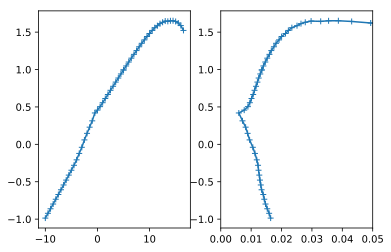

In [6]:
# Plot something
(fig,ax) = plt.subplots(1,2)
ax[0].plot(alv,clv,'-+')
ax[1].plot(cdv,clv,'-+')
ax[1].set_xlim(0,.05)

In [17]:
node=bl[0].bl_wk.nodes[1]
node_prev = bl[0].bl_wk.nodes[0]
bl[0].bl_wk.nodes[9].HK

1.000001

[1] Melin, T. (2013). Parametric Airfoil Catalog: An Aerodynamic and Geometric Comparison Between Parametrized and Point Cloud Airfoils - Part 1 and 2.